# This is a notebook that shows how to produce Grad-CAM visualizations for ALBEF

# 1. Set the paths for model checkpoint and configuration

In [247]:
model_path = '/net/acadia10a/data/zkhan/ALBEF-checkpoints/ablations/shared_txt_enc_pseudolabels_multimodal_mim_momentum/checkpoint_29.pth'
bert_config_path = 'configs/shared_bert.json'
use_cuda = True

In [248]:
import torchvision

# 2. Model defination

In [2]:
from functools import partial
from models.vit import VisionTransformer
from models.med import BertConfig, BertModel
from models.tokenization_bert import BertTokenizer

import torch
from torch import nn
from torchvision import transforms
import torch.nn.functional as F

import json

class ViTConceptPredictor(nn.Module):
    def __init__(self, concepts=30522, embed_dim=256):
        super().__init__()

        self.visual_encoder = VisionTransformer(
            img_size=384, patch_size=16, embed_dim=768, depth=12, num_heads=12, 
            mlp_ratio=4, qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6),
            mask_token=False
        ) 
        
        self.concept_head = nn.Linear(embed_dim, concepts) 
        self.vision_proj = nn.Linear(768, embed_dim)

        
    def forward(self, image, layer=11):
        image_embeds = self.visual_encoder(image, register_blk=layer) 
        image_atts = torch.ones(image_embeds.size()[:-1],dtype=torch.long).to(image.device)  
        image_feat = F.normalize(self.vision_proj(image_embeds[:,0,:]),dim=-1)
        pseudolabel_predictions = self.concept_head(image_feat)
        return pseudolabel_predictions

# 3. Text Preprocessing

In [3]:
import re

def pre_caption(caption,max_words=30):
    caption = re.sub(
        r"([,.'!?\"()*#:;~])",
        '',
        caption.lower(),
    ).replace('-', ' ').replace('/', ' ')

    caption = re.sub(
        r"\s{2,}",
        ' ',
        caption,
    )
    caption = caption.rstrip('\n') 
    caption = caption.strip(' ')

    #truncate caption
    caption_words = caption.split(' ')
    if len(caption_words)>max_words:
        caption = ' '.join(caption_words[:max_words])            
    return caption

# 4. Image Preprocessing and Postpressing

In [4]:
from PIL import Image

import cv2
import numpy as np

from skimage import transform as skimage_transform
from scipy.ndimage import filters
from matplotlib import pyplot as plt

def getAttMap(img, attMap, blur = True, overlap = True, thresh=90):
    attMap -= attMap.min()
    if attMap.max() > 0:
        attMap /= attMap.max()
    #attMap[attMap < np.percentile(attMap, thresh)] = 0
    attMap = skimage_transform.resize(attMap, (img.shape[:2]), order = 3, mode = 'constant')
    if blur:
        attMap = filters.gaussian_filter(attMap, 0.02*max(img.shape[:2]))
        attMap -= attMap.min()
        attMap /= attMap.max()
    #attMap[attMap < np.percentile(attMap, 90)] = 0
    cmap = plt.get_cmap('jet')
    attMapV = cmap(attMap)
    attMapV = np.delete(attMapV, 3, 2)
    if overlap:
        attMap = 1*(1-attMap**0.9).reshape(attMap.shape + (1,))*img + (attMap**0.9).reshape(attMap.shape+(1,)) * attMapV
    return attMap


normalize = transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

transform = transforms.Compose([
    transforms.Resize((384,384),interpolation=Image.BICUBIC),
    transforms.ToTensor(),
    normalize,
])     

/home/mai/zkhan/miniconda3/envs/ssl/lib/python3.7/site-packages/torchvision/transforms/transforms.py:281: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


# 5. Load model and tokenizer

In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

model = ViTConceptPredictor()

checkpoint = torch.load(model_path, map_location='cpu')              
msg = model.load_state_dict(checkpoint,strict=False)
model.eval()

#block_num = 8

#model.text_encoder.base_model.base_model.encoder.layer[block_num].crossattention.self.save_attention = True

if use_cuda:
    model.cuda() 

# 6. Load Image and Text

In [6]:
with open('/net/acadia10a/data/zkhan/coco2017/pretrain-pairs.json', 'r') as f:
    coco = json.load(f)

In [112]:
import random
sample_idx = random.choice(range(len(coco)))
sample = coco[sample_idx]

In [113]:
image_path = sample['image']
image_pil = Image.open(image_path).convert('RGB')   
image = transform(image_pil).unsqueeze(0)  

caption = sample['caption']
text = pre_caption(caption)
text_input = tokenizer(text, return_tensors="pt")

if use_cuda:
    image = image.cuda()
    text_input = text_input.to(image.device)

A man riding a wave on a surfboard while others look on. 


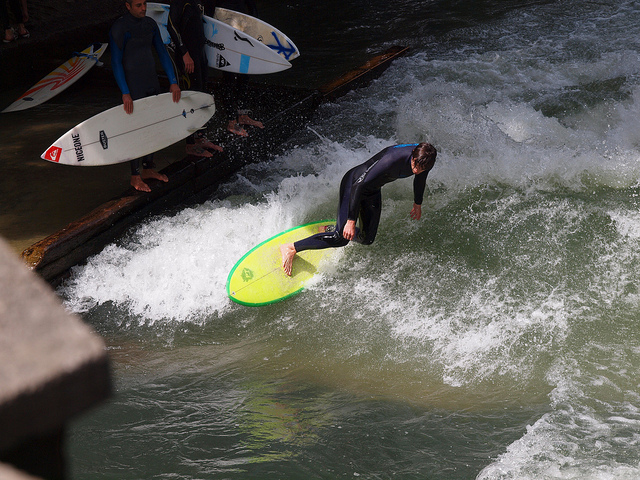

In [114]:
print(caption)
image_pil

In [164]:
concept = 'riding'
concept_label = tokenizer.encode(concept, add_special_tokens=False)[0]

# 7. Compute GradCAM

In [165]:
layer = 10
output = model(image, layer=layer)
# loss = F.sigmoid(output[:, concept_label])
hard_targets = torch.zeros(1, tokenizer.vocab_size).cuda()
hard_targets[:, concept_label] = 1
loss = F.binary_cross_entropy_with_logits(output, hard_targets)

model.zero_grad()
loss.backward()    

with torch.no_grad():
    #ask = text_input.attention_mask.view(text_input.attention_mask.size(0),1,-1,1,1)

    grads=model.visual_encoder.blocks[layer].attn.get_attn_gradients()
    cams=model.visual_encoder.blocks[layer].attn.get_attention_map()

    cams = cams[:, :, :, 1:].reshape(image.size(0), 12, -1, 24, 24)
    grads = grads[:, :, :, 1:].clamp(0).reshape(image.size(0), 12, -1, 24, 24) 

    gradcam = cams * grads
    gradcam = gradcam[0].mean(0).cpu().detach()

# 8. Visualize GradCam for a concept

Text(0.5, 0, 'riding')

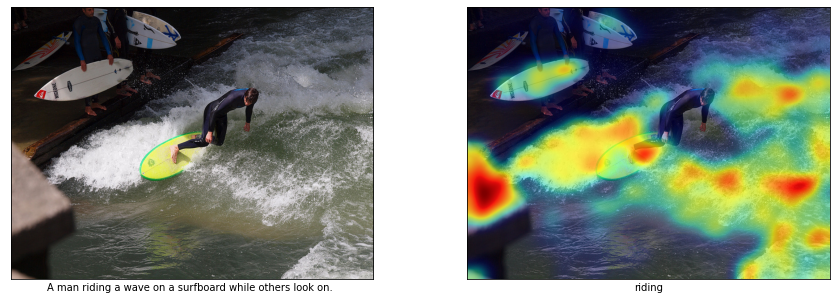

In [166]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(15,5))

rgb_image = cv2.imread(image_path)[:, :, ::-1]
rgb_image = np.float32(rgb_image) / 255

ax1.imshow(rgb_image)
ax1.set_yticks([])
ax1.set_xticks([])
ax1.set_xlabel(caption)

gradcam_image = getAttMap(rgb_image, gradcam[0], overlap=True, blur=True, thresh=90)
ax2.imshow(gradcam_image)
ax2.set_yticks([])
ax2.set_xticks([])
ax2.set_xlabel(concept)

In [301]:
from pathlib import Path
from tqdm.notebook import tqdm

In [298]:
def compute_gradcam(concept: str, layer: int, tokenizer, model, zero_others: bool, image):
    concept_label = tokenizer.encode(concept, add_special_tokens=False)[0]
    output = model(image, layer=layer)
    if not zero_others:
        loss = F.sigmoid(output[:, concept_label])
    else:
        hard_targets = torch.zeros(1, tokenizer.vocab_size).cuda()
        hard_targets[:, concept_label] = 1
        loss = F.binary_cross_entropy_with_logits(output, hard_targets)
    model.zero_grad()
    loss.backward()    

    with torch.no_grad():
        grads=model.visual_encoder.blocks[layer].attn.get_attn_gradients()
        cams=model.visual_encoder.blocks[layer].attn.get_attention_map()

        cams = cams[:, :, :, 1:].reshape(image.size(0), 12, -1, 24, 24)
        grads = grads[:, :, :, 1:].clamp(0).reshape(image.size(0), 12, -1, 24, 24) 

        gradcam = cams * grads
        gradcam = gradcam[0].mean(0).cpu().detach()
    return gradcam

In [281]:
def save_image(image_path: str, dirname: Path, caption: str):
    fig, ax1 = plt.subplots(ncols=1, nrows=1, figsize=(5,5))

    rgb_image = cv2.imread(image_path)[:, :, ::-1]
    rgb_image = np.float32(rgb_image) / 255

    ax1.imshow(rgb_image)
    ax1.set_yticks([])
    ax1.set_xticks([])
    ax1.set_xlabel(caption)
    plt.savefig(dirname / 'original.jpg')
    plt.close()

In [282]:
def save_gradcam(image_path: str, gradcam, use_cls: bool, concept: str, dirname: Path):
    fig, ax1 = plt.subplots(ncols=1, nrows=1, figsize=(5,5))

    rgb_image = cv2.imread(image_path)[:, :, ::-1]
    rgb_image = np.float32(rgb_image) / 255
    
    token_idx = 0 if use_cls else random.choice(np.arange(1, len(gradcam)-1))

    gradcam_image = getAttMap(rgb_image, gradcam[token_idx], overlap=True, blur=True, thresh=90)
    ax1.imshow(gradcam_image)
    ax1.set_yticks([])
    ax1.set_xticks([])
    ax1.set_xlabel(concept)
    plt.savefig(dirname / f'{concept}.jpg')
    plt.close()
    return gradcam_image

In [269]:
# Make matplotlib stfu
import logging 
logging.basicConfig(level=logging.ERROR)

In [ ]:
import random
coco_indices = np.arange(len(coco))
random.shuffle(coco_indices)

root = Path('./concept-grad-cams')
root.mkdir(exist_ok=True, parents=True)
for sample_idx in tqdm(coco_indices[:100]):
    dirname = root / str(sample_idx)
    dirname.mkdir(exist_ok=True)
    sample = coco[sample_idx]
    image_path = sample['image']
    caption = sample['caption']
    usable_tokens = pre_caption(caption).split(' ')
    image_pil = Image.open(image_path).convert('RGB')   
    image = transform(image_pil).unsqueeze(0).cuda()
    save_image(image_path, caption=caption, dirname=dirname)
    layers = (0, 3, 10, 11) # only grab these specific layers
    n_concepts = len(usable_tokens)
    gradcams_by_layer = {_: [None] * n_concepts for _ in layers}
    for layer in gradcams_by_layer:
        for concept_position, concept in enumerate(usable_tokens):
            gradcam = compute_gradcam(
                concept=concept,
                layer=layer,
                tokenizer=tokenizer,
                model=model,
                zero_others=False,
                image=image,
            )
            (dirname / str(layer)).mkdir(exist_ok=True)
            gradcam_image = save_gradcam(
            image_path=image_path,
            gradcam=gradcam,
            use_cls=True,
            concept=concept,
            dirname = dirname / str(layer)
            )
            gradcams_by_layer[layer][concept_position] = gradcam_image
    # Draw the tapestry for the image. 
    fig_height = 2 * len(layers)
    fig_width = 2 * len(usable_tokens)
    fig, axes = plt.subplots(nrows=len(layers), ncols=len(usable_tokens), figsize=(fig_width, fig_height))
    for axes_idx_for_layer, layer in enumerate(layers):
        gradcams_for_layer = gradcams_by_layer[layer]
        axes_for_layer = axes[axes_idx_for_layer]
        for ax, img_to_plot, concept_name in zip(axes_for_layer, gradcams_for_layer, usable_tokens):
            ax.imshow(img_to_plot)
            ax.set_yticks([])
            ax.set_xticks([])
            ax.set_xlabel(concept_name)
            ax.set_ylabel(f'layer={layer}')
    plt.subplots_adjust(wspace=0)
    plt.tight_layout()
    plt.savefig(dirname / 'tapestry.jpg')
    plt.close()

  0%|          | 0/100 [00:00<?, ?it/s]

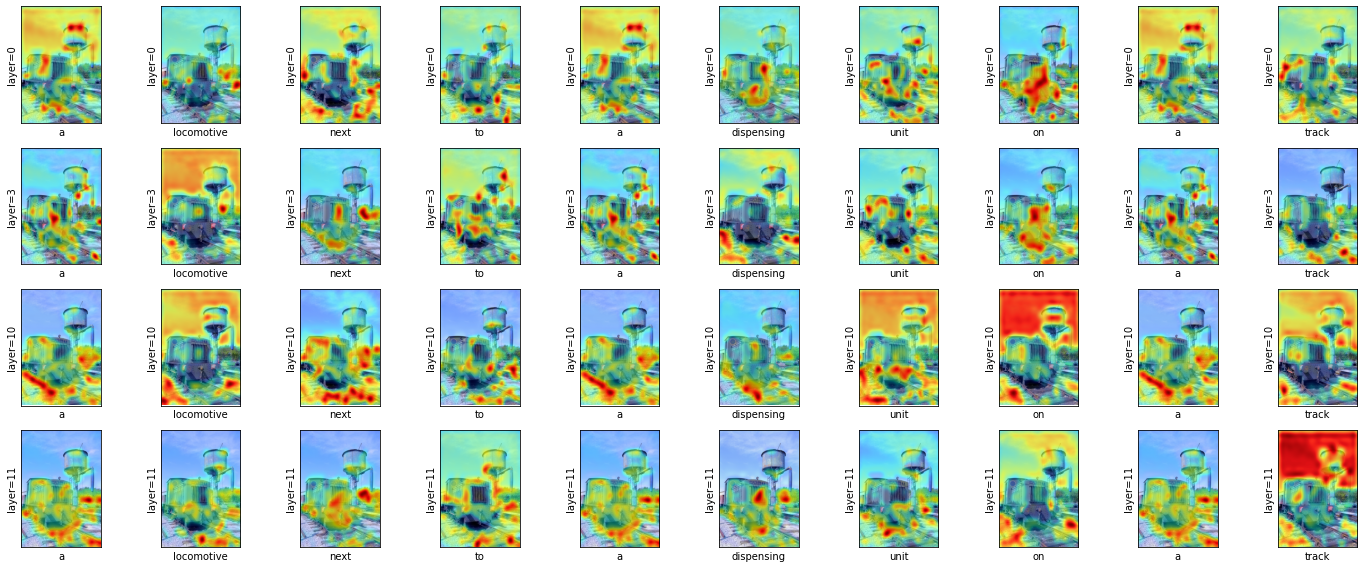

In [299]:
fig_height = 2 * len(layers)
fig_width = 2 * len(usable_tokens)
fig, axes = plt.subplots(nrows=len(layers), ncols=len(usable_tokens), figsize=(fig_width, fig_height))
for axes_idx_for_layer, layer in enumerate(layers):
    gradcams_for_layer = gradcams_by_layer[layer]
    axes_for_layer = axes[axes_idx_for_layer]
    for ax, img_to_plot, concept_name in zip(axes_for_layer, gradcams_for_layer, usable_tokens):
        ax.imshow(img_to_plot)
        ax.set_yticks([])
        ax.set_xticks([])
        ax.set_xlabel(concept_name)
        ax.set_ylabel(f'layer={layer}')
plt.subplots_adjust(wspace=0)
plt.tight_layout()

In [285]:
sample_idx

83685